In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing the necessary libraries

In [3]:
import os
import numpy as np
import random
import tensorflow as tf
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import zipfile

### Unzip the folder containing Training and Testing Images (In case present)

In [4]:
base_dir = os.getcwd()+'/drive/MyDrive/dataset80-20'

train_dir = os.path.join(base_dir, 'training')
train_cnv_dir = os.path.join(train_dir, 'cnv')
train_normal_dir = os.path.join(train_dir, 'normal')

validation_dir = os.path.join(base_dir, 'testing')
validation_cnv_dir = os.path.join(validation_dir, 'cnv')
validation_normal_dir = os.path.join(validation_dir, 'normal')

print('total training cnv images :', len(os.listdir(train_cnv_dir)))
print('total training normal images :', len(os.listdir(train_normal_dir)))
print('total validation cnv images :', len(os.listdir(validation_cnv_dir)))
print('total validation normal images :', len(os.listdir(validation_normal_dir)))

total training cnv images : 6413
total training normal images : 6413
total validation cnv images : 1603
total validation normal images : 1603


### Understanding directory from inside

In [5]:
train_cnv_fnames = os.listdir(train_cnv_dir)
train_normal_fnames = os.listdir(train_normal_dir)

print("Printing five cnv images name in train_cnv_dir: ", train_cnv_fnames[:5])
print("Printing five normal images name in train_normal_dir: ", train_normal_fnames[:5])

Printing five cnv images name in train_cnv_dir:  ['CNV-9662498-20.jpeg', 'CNV-9662498-33.jpeg', 'CNV-9662498-19.jpeg', 'CNV-9662498-31.jpeg', 'CNV-9662498-29.jpeg']
Printing five normal images name in train_normal_dir:  ['NORMAL-786647-7.jpeg', 'NORMAL-795393-2.jpeg', 'NORMAL-788137-3.jpeg', 'NORMAL-785813-5.jpeg', 'NORMAL-786647-8.jpeg']


### Visualizing Images Randomly to check if everything is working the way we expect

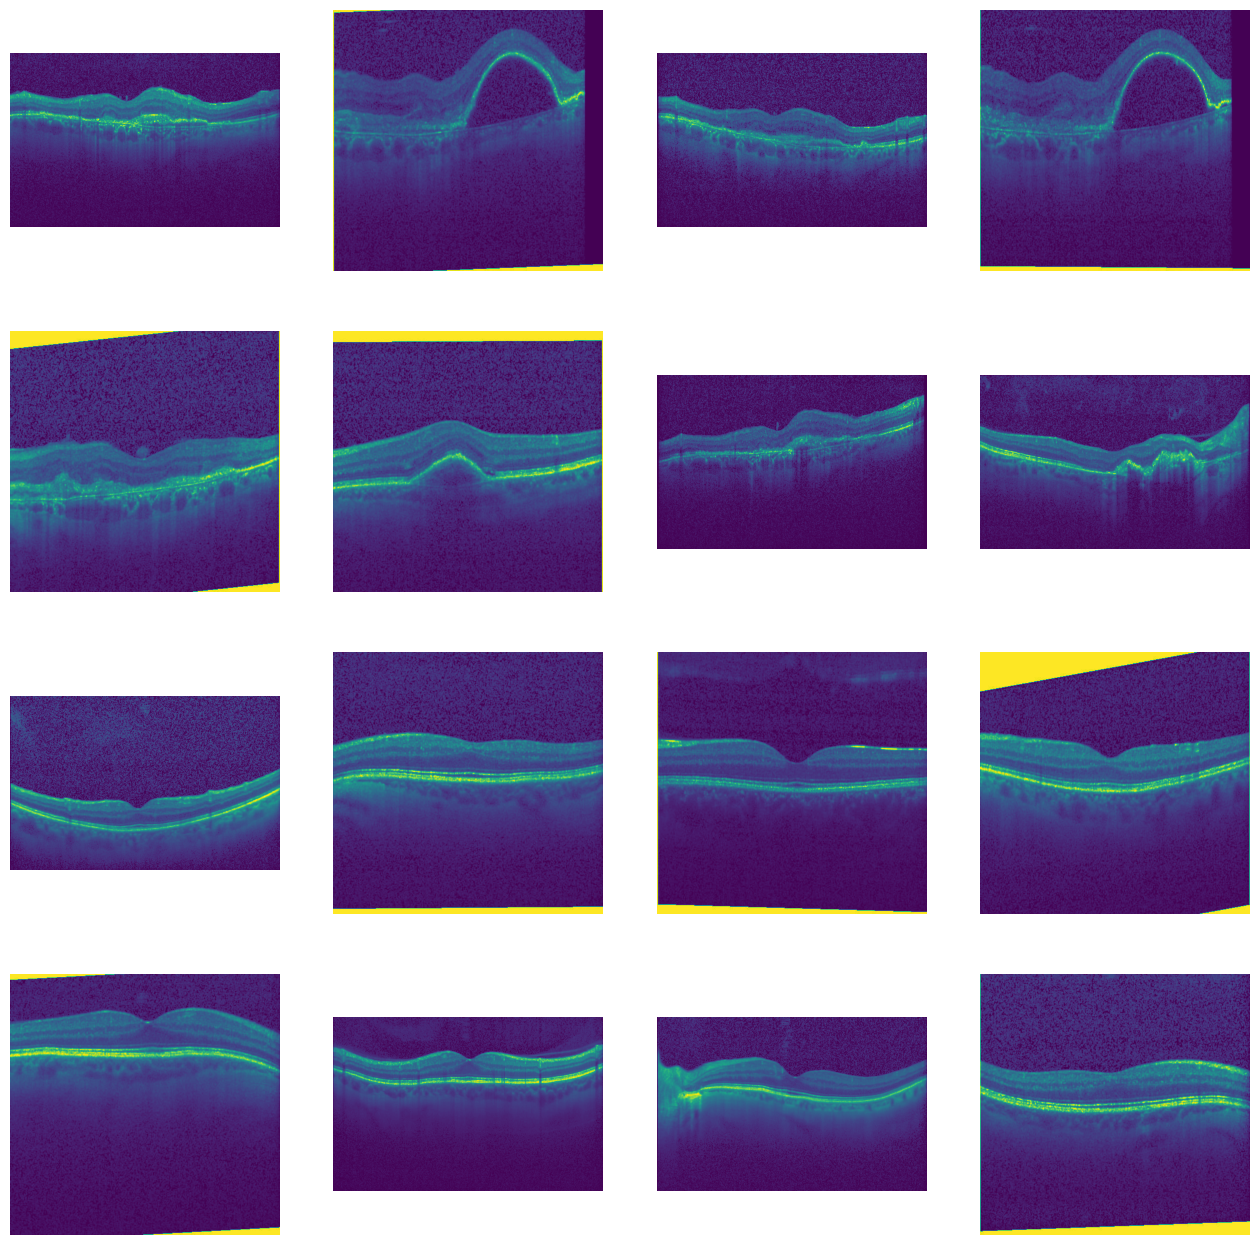

In [ ]:
import cv2
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4
pic_index = 0 # Index for iterating over images

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index+=8
next_cnv_pix = [os.path.join(train_cnv_dir, fname)
                for fname in train_cnv_fnames[ pic_index-8:pic_index]
               ]
next_normal_pix = [os.path.join(train_normal_dir, fname)
                for fname in train_normal_fnames[ pic_index-8:pic_index]
               ]
for i, img_path in enumerate(next_cnv_pix+next_normal_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(img_path)

    plt.imshow(img)
plt.show()

### Loading inceptionV3 model, loading its weight, and freezing its layers

In [ ]:

pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = None)

for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

### Customizing InceptionV3 model for our own need

In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer taken from InceptionV3 output shape: ', last_layer.output_shape)

last_output = last_layer.output
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)

model = Model( pre_trained_model.input, x)

last layer taken from InceptionV3 output shape:  (None, 7, 7, 768)


### Compiling the model

In [ ]:
model.compile(optimizer = RMSprop(lr=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

### Data Augmentation using ImageDataGenerator

In [6]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1.0/255.,rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

### Loading Images directly from directory without loading into RAM

In [7]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150))

Found 12826 images belonging to 2 classes.


In [8]:
# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary',
                                                          target_size = (150, 150))

Found 3206 images belonging to 2 classes.


In [9]:
num_classes =train_generator.class_indices
print(num_classes)

{'cnv': 0, 'normal': 1}


### Fitting the model

In [ ]:
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

<ipython-input-13-96909f157dac>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20


In [ ]:
file_path = '/content/drive/MyDrive/models 70-30/inceptionv3_model-70-30.h5'

# Save the model as an HDF5 file
model.save(file_path)

print(f"InceptionV3 model saved as '{file_path}'.")

### Evaluating model

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [20]:
from tensorflow.keras.models import load_model

model_path = '/content/drive/MyDrive/models 80-20/inceptionv3_model-80-20.h5'
model = load_model(model_path)

In [21]:
testing_dir ='/content/drive/MyDrive/testing'
testing_datagen = ImageDataGenerator(rescale = 1.0/255.)
testing_generator =  testing_datagen.flow_from_directory( testing_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary',
                                                          target_size = (150, 150))
num_classes =train_generator.class_indices
print(num_classes)

Found 484 images belonging to 2 classes.
{'cnv': 0, 'normal': 1}


In [22]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# Evaluate the model on the validation set
testing_steps = len(testing_generator)
testing_generator.reset()  # Reset the generator to start from the beginning

predictions = model.predict(testing_generator, steps=testing_steps, verbose=1)
predicted_classes = np.round(predictions)  # Assuming binary classification

# Get the true labels
true_classes = testing_generator.classes

# Calculate confusion matrix
confusion = confusion_matrix(true_classes, predicted_classes)

# Calculate classification report, including precision and recall
classification_rep = classification_report(true_classes, predicted_classes, target_names=['cnv', 'normal'])

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)

print("Confusion Matrix:\n", confusion)
print("\nClassification Report:\n", classification_rep)
print("\nAccuracy:", accuracy)


25/25 [==============================] - 25s 886ms/step
Confusion Matrix:
 [[122 120]
 [145  97]]

Classification Report:
               precision    recall  f1-score   support

         cnv       0.46      0.50      0.48       242
      normal       0.45      0.40      0.42       242

    accuracy                           0.45       484
   macro avg       0.45      0.45      0.45       484
weighted avg       0.45      0.45      0.45       484


Accuracy: 0.4524793388429752


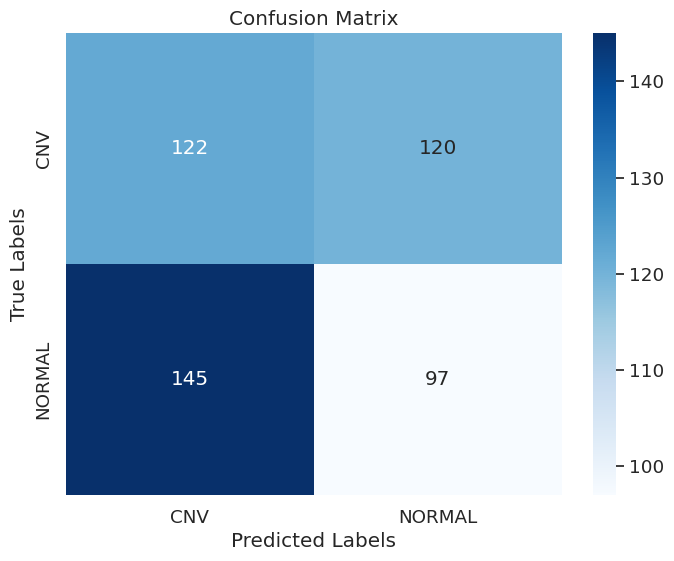

In [23]:
from PIL import Image
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os

# Calculate the confusion matrix
confusion = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=["CNV", "NORMAL"], yticklabels=["CNV", "NORMAL"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

model_path = '/content/drive/MyDrive/models 70-30/inceptionv3_model-70-30.h5'
loaded_model = load_model(model_path)
from tensorflow.keras.preprocessing.image import load_img, img_to_array

image_path = '/content/drive/MyDrive/normal sample/NORMAL-697826-1.jpeg'  # Replace with the path to your image
image = load_img(image_path, target_size=(150, 150))
image_array = img_to_array(image)
image_array = image_array / 255.0  # Normalize pixel values to [0, 1]
image_array = image_array.reshape((1,) + image_array.shape)  # Reshape for model input
predictions = loaded_model.predict(image_array)
threshold = 0.5
if predictions[0] < threshold:
    print("Class: CNV")
else:
    print("Class: Normal")


Found 484 images belonging to 2 classes.
31/31 [==============================] - 22s 722ms/step


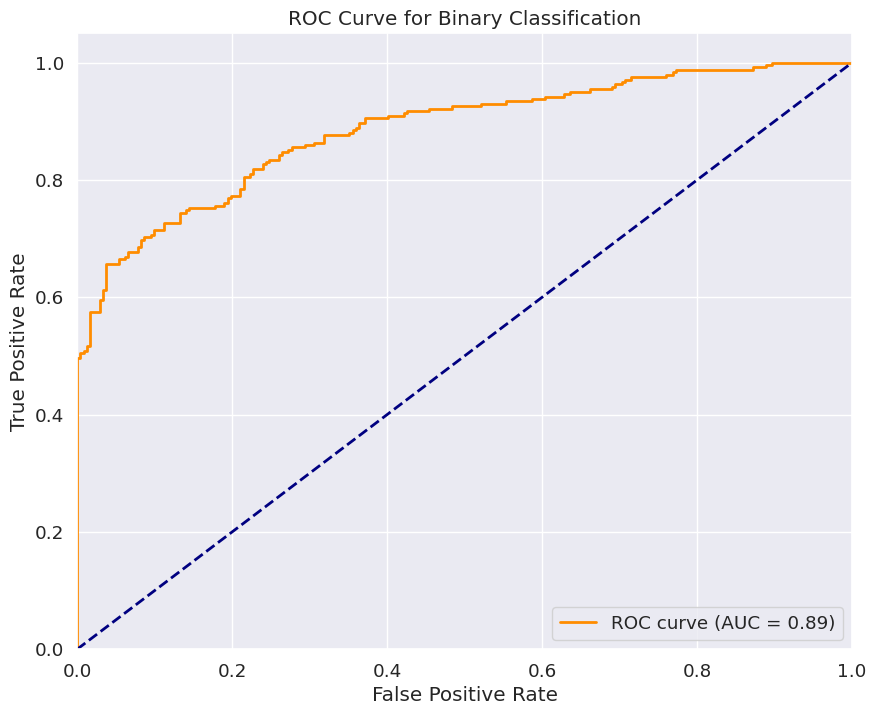

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Data Generator for your test dataset
testing_datagen = ImageDataGenerator(rescale=1./255)  # Make sure to apply the same preprocessing as during training
testing_generator = testing_datagen.flow_from_directory(
    "/content/drive/MyDrive/testing",
    target_size=(150, 150),  # Adjust the target size as needed
    batch_size=16,  # Adjust batch size as needed
    class_mode='binary',  # Assuming binary classification
    shuffle=False  # Important: Ensure that the data generator doesn't shuffle the data
)

# Predict probabilities for the test dataset
predictions = model.predict(testing_generator, steps=len(testing_generator), verbose=1)

# Assuming you have binary labels (0 or 1)
true_labels = testing_generator.classes

# Calculate the ROC curve and ROC AUC
fpr, tpr, _ = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Binary Classification')
plt.legend(loc="lower right")
plt.show()
